## Evaluation of sci-mtChIL-seq

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(GenomicRanges)
library(GenomicFeatures)
library(Seurat)
library(Signac)

library(tidyverse)
source('R/mytools.R')

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: AnnotationDbi



In [ ]:
meta_st <- read_tsv("data/meta/meta_single_targeted.tsv.gz",show_col_types = F) 
head(meta_st)

experiment,sample,condition,target,rep,cell_name,nFragment
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
single-targeted,NIH3T3,Growth,H3K4me3,r1,R0668_L002_3_63_ACAACG,22261
single-targeted,NIH3T3,Growth,H3K4me3,r1,R0668_L002_3_23_AGTACG,21195
single-targeted,NIH3T3,Growth,H3K4me3,r1,R0668_L002_3_57_GAAGTC,20394
single-targeted,NIH3T3,Growth,H3K4me3,r1,R0668_L002_3_19_AGGAAG,19686
single-targeted,NIH3T3,Growth,H3K4me3,r1,R0668_L002_3_60_ACGGTT,19361
single-targeted,NIH3T3,Growth,H3K4me3,r1,R0668_L002_3_55_AACCGT,19310


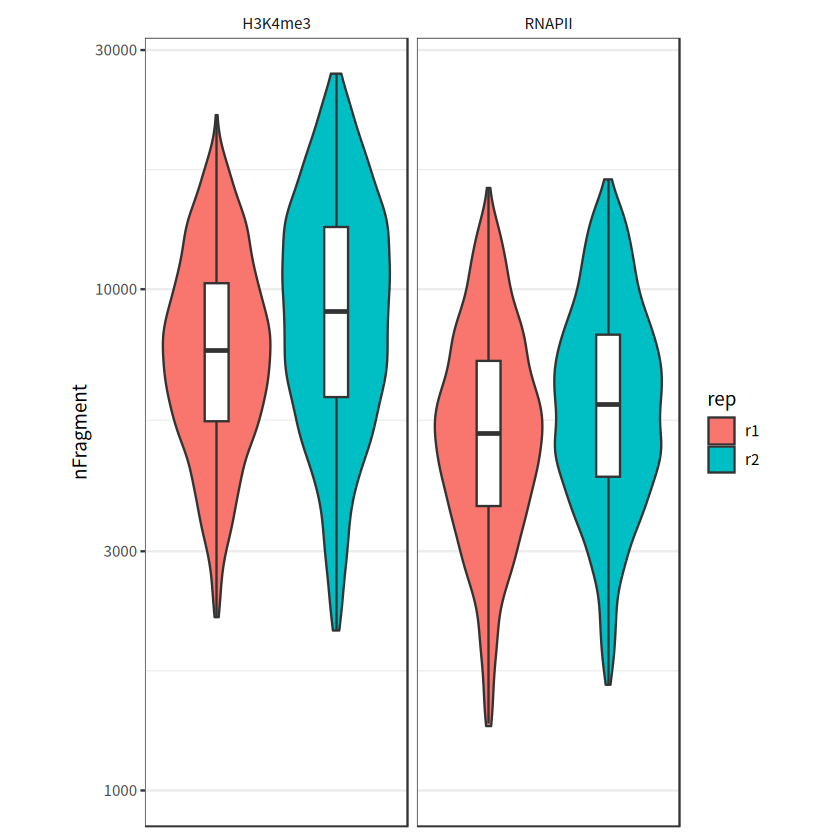

In [3]:
meta_st %>%
  ggplot(aes(rep,nFragment,fill = rep)) + 
    geom_violin(scale = 'width') + 
    geom_boxplot(fill = 'white',width = .2,
                 outlier.color = NA) +
    theme_bw() +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.grid.major.x = element_blank(),
          strip.background = element_blank(),
          aspect.ratio = 3) +
    scale_y_log10(limits = c(1000,NA)) +
    facet_wrap(~target)  

In [4]:
mgene <- genes(EnsDb.Mmusculus.v79::EnsDb.Mmusculus.v79)
seqlevelsStyle(mgene) <- "UCSC"
mgene_coding <- mgene %>% 
  subset(gene_biotype == "protein_coding") %>%
  subset(symbol != '') %>%
  subset(seqnames %in% paste0("chr",c(1:19,'X','Y')))
idx <- mgene_coding %>% as_tibble() %>%
  slice_max(order_by = width,n = 1,by = symbol) %>%
  pull(gene_id)
mgene_coding_uni <- mgene_coding %>%
  subset(gene_id %in% idx)

In [ ]:
## Load RNAseq data

rna <- read_tsv('data/nih3t3_RNAseq_NormalizedCount.tsv.gz',show_col_types = F) 
rna_exprs <- rna[1:4]
keys <- c("MyoDminus","D0","D72")
for(i in 1:length(keys)){
  mu <- apply(rna[,grep(keys[i],colnames(rna))],1,mean)
  rna_exprs[[keys[i]]] <- (10^6)*mu/sum(mu)
}
rna_exprs <- rna_exprs %>%
  arrange(-MyoDminus) %>%
  filter(ensembl %in% mgene_coding_uni$gene_id) %>%
  dplyr::select(symbol,MyoDminus) 

rna_exprs_groups <- rna_exprs %>%
  mutate(group = as.integer(cut(1:nrow(rna_exprs),breaks = 5))) %>%
  dplyr::select(symbol,group)

In [ ]:
frags_st <- c(
  RNAPII_r1 = 'fragments_st_r1_RNAPII.bed.gz',
  RNAPII_r2 = 'fragments_st_r2_RNAPII.bed.gz',
  H3K4me3_r1 = 'fragments_st_r1_H3K4me3.bed.gz',
  H3K4me3_r2 = 'fragments_st_r2_H3K4me3.bed.gz'
  ) %>%
  map(~rtracklayer::import(sprintf("data/bed/part1_1/%s",.x),format = 'bed'))

In [7]:
aggr_rnapgb <- c(
  frags_st[1:2],
  list(
    RNAPII_m = c(frags_st$RNAPII_r1,frags_st$RNAPII_r2)
    )
  )
sfs <- map_int(aggr_rnapgb,length)
aggr_rnapgb <- aggr_rnapgb %>%
  map(~findOverlapPairs(.x,extend(mgene_coding_uni,2000,2000))) %>%
  map(~as_tibble(.x@second) %>%
        mutate(
          width = width - 4000,
          frag = start(.x@first),
          tss =  ifelse(strand == "+",start+2000,end-2000),
          relative = ifelse(strand == "+",frag-tss,-1*(frag-tss)),
          relative = round(8000*relative/width)
          ) %>%
        count(symbol,relative))

gf <- function(x,sdev = 20) stats::filter(x,dnorm(seq(-1*sdev,1*sdev)-0.5,0,sdev))
template <- expand.grid(group = 1:5,relative = -1000:9000)
aggr_rnapgb_s <- aggr_rnapgb %>%
  map2(sfs,~{
    .x %>%
      filter(relative > -1000,relative < 9000) %>%
      inner_join(rna_exprs_groups,by = 'symbol') %>%
      reframe(n = sum(n),.by = c(group,relative)) %>%
      mutate(cpm = (10^6)*n/.y) %>%
      left_join(template,.,by = c('group','relative')) %>%
      arrange(group,relative) %>%
      mutate(
        n = ifelse(is.na(n),0,n),
        cpm = ifelse(is.na(cpm),0,cpm)
        ) %>%
      nest(.by = group) %>%
      mutate(data = map(data,~mutate(.x,smoothed = gf(cpm)))) %>%
      mutate(data = map(data,~mutate(.x,dens = smoothed/sum(smoothed,na.rm = TRUE)))) %>%
      unnest(data) %>%
      na.omit()
  })

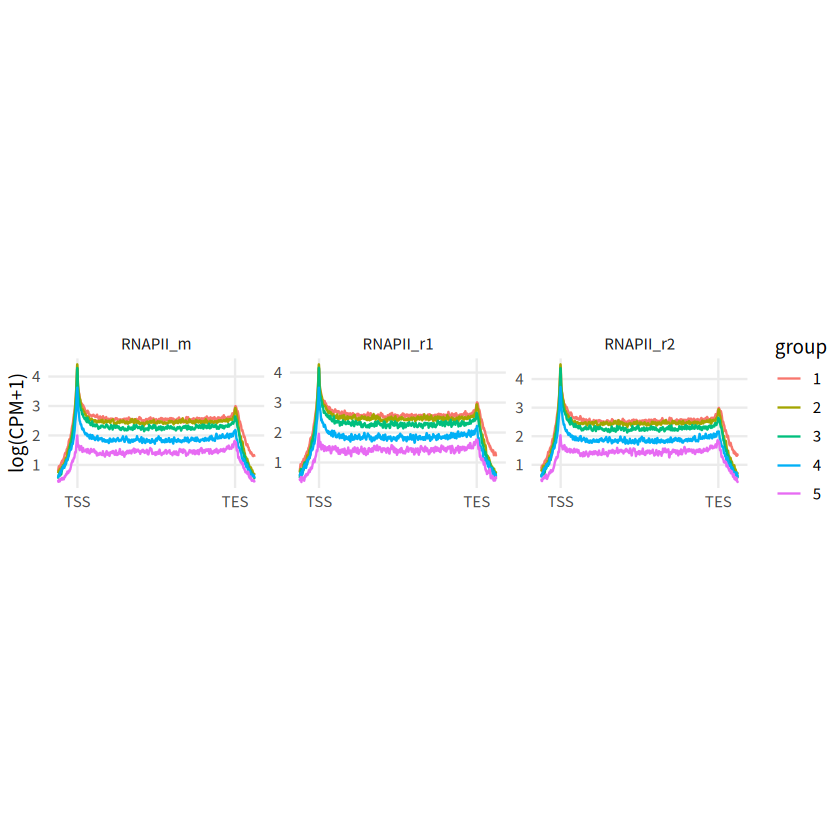

In [8]:
aggr_rnapgb_s %>%
  bind_rows(.id = "data") %>%
  mutate(group = as.factor(group)) %>%
  ggplot(aes(relative,log(smoothed+1),color = group)) + 
    theme_minimal() +
    theme(aspect.ratio = .6,panel.grid.minor = element_blank(),
          axis.title.x = element_blank()) +
    geom_line() + facet_wrap(~data,scales = 'free') +
    scale_x_continuous(breaks = c(0,8000),labels = c('TSS','TES')) +
    labs(y = "log(CPM+1)")

In [9]:
aggr_k4tss <- c(
  frags_st[3:4],
  list(
    H3K4me3_m = c(frags_st$H3K4me3_r1,frags_st$H3K4me3_r2)
    )
  )
sfs <- map_int(aggr_k4tss,length)
aggr_k4tss <- aggr_k4tss %>%
  map(~findOverlapPairs(.x,flank(mgene_coding_uni,5000,both = TRUE))) %>%
  map(~as_tibble(.x@second) %>%
        mutate(
          frag = start(.x@first),
          tss =  start+5000,
          relative = ifelse(strand == "+",frag-tss,-1*(frag-tss))
          ) %>%
        count(symbol,relative))

template <- expand.grid(group = 1:5,relative = -5000:5000)
aggr_k4tss_s <- aggr_k4tss %>%
  map2(sfs,~{
    .x %>%
      inner_join(rna_exprs_groups,by = 'symbol') %>%
      reframe(n = sum(n),.by = c(group,relative)) %>%
      mutate(cpm = (10^6)*n/.y) %>%
      left_join(template,.,by = c('group','relative')) %>%
      arrange(group,relative) %>%
      mutate(
        n = ifelse(is.na(n),0,n),
        cpm = ifelse(is.na(cpm),0,cpm)
        ) %>%
      nest(.by = group) %>%
      mutate(data = map(data,~mutate(.x,smoothed = gf(cpm)))) %>%
      mutate(data = map(data,~mutate(.x,dens = smoothed/sum(smoothed,na.rm = TRUE)))) %>%
      unnest(data) %>%
      na.omit()
  })

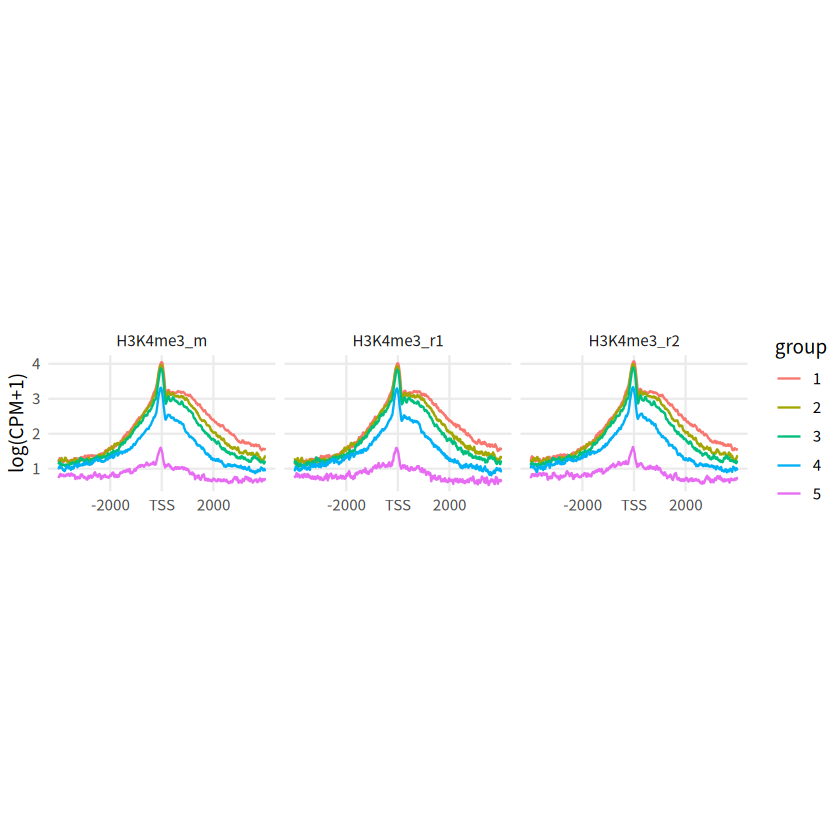

In [10]:
aggr_k4tss_s %>%
  bind_rows(.id = "data") %>%
  filter(abs(relative) <= 4000) %>%
  mutate(group = as.factor(group)) %>%
  ggplot(aes(relative,log(smoothed+1),color = group)) + 
    theme_minimal() +
    theme(aspect.ratio = .6,panel.grid.minor = element_blank(),
          axis.title.x = element_blank()) +
    geom_line() + facet_wrap(~data) +
    scale_x_continuous(labels = c('-2000','TSS','2000'),breaks = c(-2000,0,2000)) +
    labs(y = "log(CPM+1)")

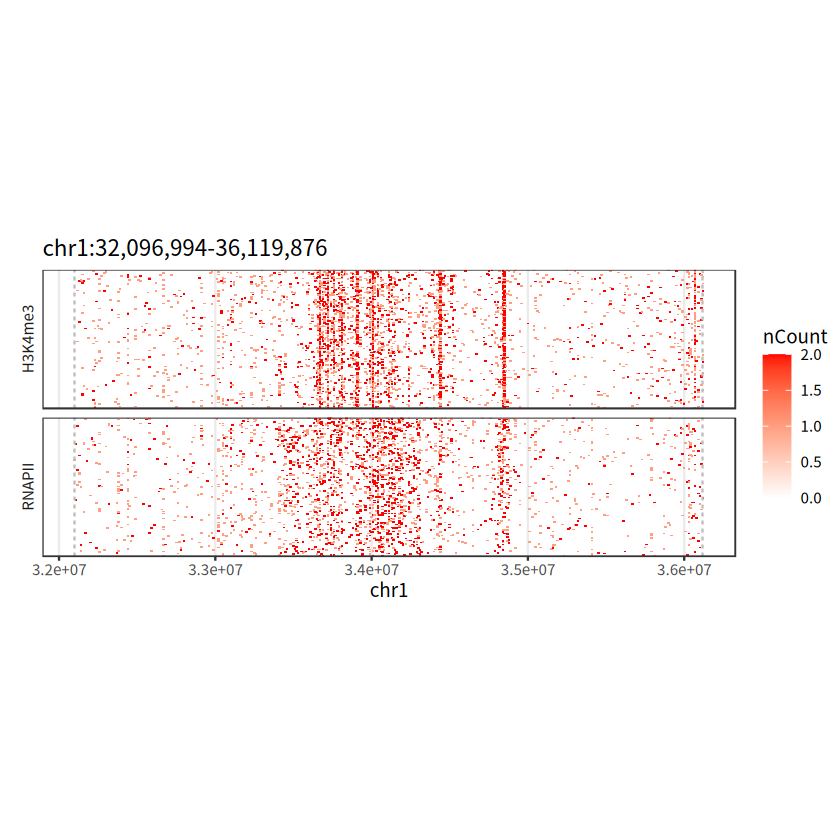

In [11]:
usereg <- GRanges('chr1',ranges = IRanges(32100000,36120000))
wid <- 10000

frags_st_usereg <- list(
  RNAPII  = c(frags_st$RNAPII_r1,
              frags_st$RNAPII_r2),
  H3K4me3 = c(frags_st$H3K4me3_r1,
              frags_st$H3K4me3_r2)
  ) %>%
  map(~findOverlapPairs(.x,usereg) %>% .@first) %>%
  map(~{
    .x %>%
      as_tibble() %>%
      mutate(tile = wid*round(start/wid)) %>%
      count(tile,name) %>%
      mutate(n = ifelse(n>2,2,n))
  }) 
nregs_st_usereg <- frags_st_usereg %>%
  map(~count(.x,name))
usecells_st <- nregs_st_usereg %>%
  map(~arrange(.x,-n) %>% pull(name) %>% head(200))

frags_st_usereg %>%
  map2(usecells_st,~{
    .x %>%
      filter(name %in% .y) %>%
      mutate(name = factor(name,levels = rev(.y)))
  }) %>%
  bind_rows(.id = 'ab') %>%
  ggplot(aes(tile,name,fill = n)) +
    geom_tile() +
    geom_vline(xintercept = 32100000,linetype = 'dashed',color = 'grey') +
    geom_vline(xintercept = 36120000,linetype = 'dashed',color = 'grey') +
    theme_bw() +
    facet_wrap(~ab,ncol = 1,scales = 'free_y',
               strip.position = 'left') +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.grid.minor = element_blank(),
          panel.grid.major.y = element_blank(),
          strip.background = element_blank(),
          aspect.ratio = .2) +
    scale_fill_gradient(low = 'white',high = 'red',limits = c(0,2)) +
    ggtitle("chr1:32,096,994-36,119,876") +
    labs(x = 'chr1',fill = "nCount")

In [ ]:
frags_mt <- c(
  RNAPII_r1 = 'fragments_mt_r1_RNAPII_H3K4me3-RNAPII.bed.gz',
  RNAPII_r2 = 'fragments_mt_r2_RNAPII_H3K4me3-RNAPII.bed.gz',
  H3K4me3_r1 = 'fragments_mt_r1_H3K4me3_H3K4me3-RNAPII.bed.gz',
  H3K4me3_r2 = 'fragments_mt_r2_H3K4me3_H3K4me3-RNAPII.bed.gz'
  ) %>%
  map(~rtracklayer::import(sprintf("data/bed/part1_2/%s",.x),format = 'bed'))

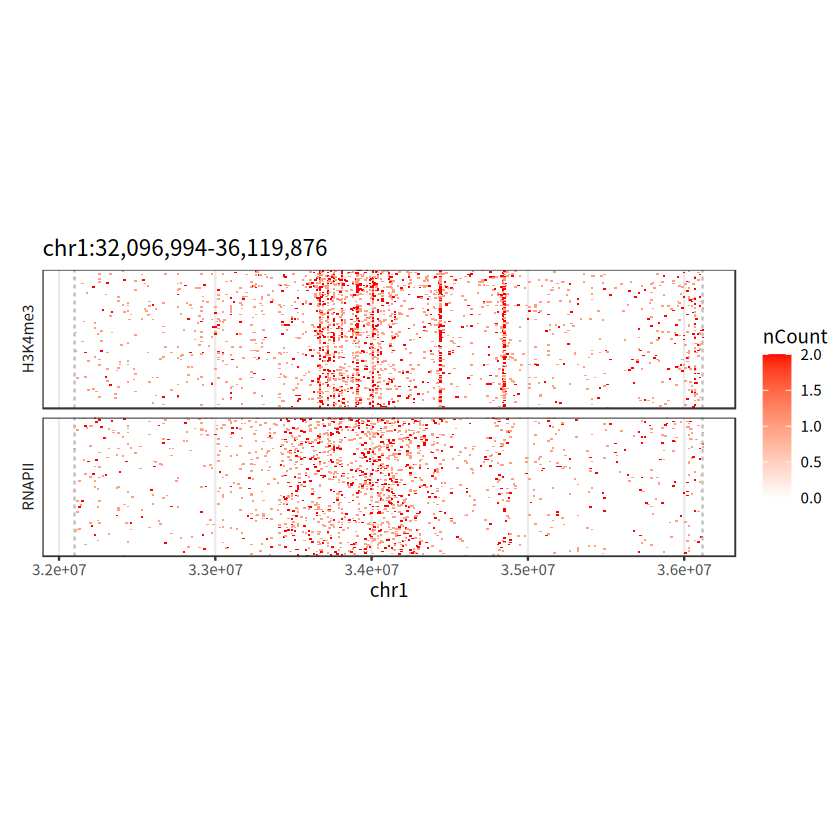

In [ ]:
frags_mt_usereg <- list(
  RNAPII  = c(frags_mt$RNAPII_r1,
              frags_mt$RNAPII_r2),
  H3K4me3 = c(frags_mt$H3K4me3_r1,
              frags_mt$H3K4me3_r2)
  ) %>%
  map(~findOverlapPairs(.x,usereg) %>% .@first) %>%
  map(~{
    .x %>%
      as_tibble() %>%
      mutate(tile = wid*round(start/wid)) %>%
      count(tile,name) %>%
      mutate(n = ifelse(n>2,2,n))
  }) 
nregs_mt_usereg <- frags_mt_usereg %>%
  map(~count(.x,name))
usecells_mt <- nregs_mt_usereg %>%
  map(~arrange(.x,-n) %>% pull(name) %>% head(200))
nregs_mt_usereg <- frags_mt_usereg %>%
  map(~count(.x,name))
nregs_mt_usereg <- inner_join(
  nregs_mt_usereg$RNAPII %>% rename(RNAPII = n),
  nregs_mt_usereg$H3K4me3 %>% rename(H3K4me3 = n),
  by = 'name'
  )
usecells_mt <- nregs_mt_usereg %>%
  arrange(-RNAPII) %>% pull(name) %>% head(200)

frags_mt_usereg %>%
  map(~{
    .x %>%
      filter(name %in% usecells_mt) %>%
      mutate(name = factor(name,levels = rev(usecells_mt)))
  }) %>%
  bind_rows(.id = 'ab') %>%
  ggplot(aes(tile,name,fill = n)) +
    geom_tile() +
    geom_vline(xintercept = 32100000,linetype = 'dashed',color = 'grey') +
    geom_vline(xintercept = 36120000,linetype = 'dashed',color = 'grey') +
    theme_bw() +
    facet_wrap(~ab,ncol = 1,scales = 'free_y',
               strip.position = 'left') +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.grid.minor = element_blank(),
          panel.grid.major.y = element_blank(),
          strip.background = element_blank(),
          aspect.ratio = .2) +
    scale_fill_gradient(low = 'white',high = 'red',limits = c(0,2)) +
    ggtitle("chr1:32,096,994-36,119,876") +
    labs(x = 'chr1',fill = "nCount")

In [ ]:
mat_st <- c(
  st_RNAPII_r1 = 'st_RNAPII_r1_5kbin.rds',
  st_RNAPII_r2 = 'st_RNAPII_r2_5kbin.rds',
  st_H3K4me3_r1 = 'st_H3K4me3_r1_5kbin.rds',
  st_H3K4me3_r2 = 'st_H3K4me3_r2_5kbin.rds'
  ) %>%
  map(~readRDS(sprintf("data/matrix/part1_1/%s",.x)))
mat_mt <- c(
  mt_RNAPII_r1 = 'mt_RNAPII_RNAPII-H3K4me3_r1_5kbin.rds',
  mt_RNAPII_r2 = 'mt_RNAPII_RNAPII-H3K4me3_r2_5kbin.rds',
  mt_H3K4me3_r1 = 'mt_H3K4me3_RNAPII-H3K4me3_r1_5kbin.rds',
  mt_H3K4me3_r2 = 'mt_H3K4me3_RNAPII-H3K4me3_r2_5kbin.rds'
  ) %>%
  map(~readRDS(sprintf("data/matrix/part1_2/%s",.x)))

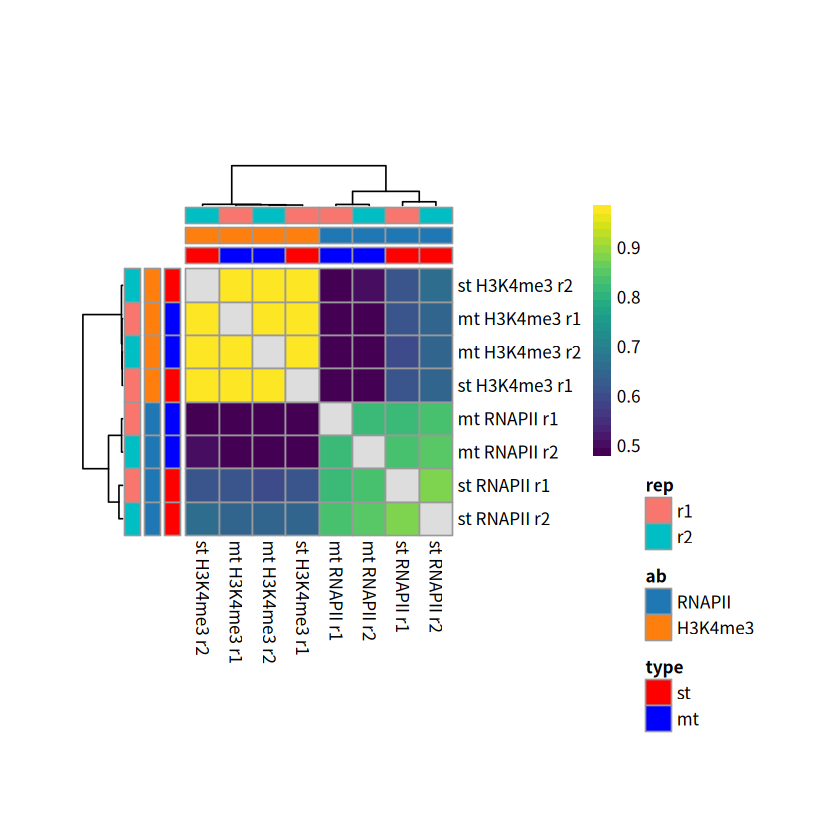

In [ ]:
mat <- c(mat_st,mat_mt)
lab <- rep(names(mat),map_int(mat,ncol))
mod <- model.matrix(~lab-1) 
colnames(mod) <- sub('lab','',colnames(mod))
mod_norm <- t(t(mod)/colSums(mod))

avg <- ldecoyMerge(mat) %*%  mod_norm
avg_cpm <- (10^6)*t(t(avg)/colSums(avg))

co <- cor(as.matrix(avg_cpm))
diag(co) <- NA
colnames(co) <- gsub("_"," ",sub('lab_','',colnames(co)))
rownames(co) <- gsub("_"," ",sub('lab_','',rownames(co)))
anno <- tibble(name = colnames(co)) %>%
  mutate(lab = name) %>%
  separate(lab,into = c("type","ab","rep"),sep = ' ') %>%
  tib2df()
pal <- list(
  ab = structure(dcolor$palette(2),names = c('RNAPII','H3K4me3')),
  rep = structure(ggColorHue(2),names = c('r1','r2')),
  type = structure(c("red","blue"),names = c('st','mt'))
  )
pheatmap::pheatmap(co,cellwidth = 20,cellheight = 20,
                   annotation_col = anno,annotation_row = anno,
                   annotation_colors = pal,
                   annotation_names_col = F,annotation_names_row = F,
                   treeheight_col = 20,treeheight_row = 20,
                   color = viridis::viridis(32))

In [ ]:
metam <- read_tsv("data/meta/meta_multi_targeted_AbMinus.tsv.gz",show_col_types = F)
sm <- c(
  `RNAPII_mtRNAPIIminus_r1` = "mt_RNAPII_RNAPII-H3K4me3_RNAPIIminus_5kbin.rds",
  `RNAPII_mtH3K4me3minus_r1` = "mt_RNAPII_RNAPII-H3K4me3_H3K4me3minus_5kbin.rds",
  `RNAPII_mt_r1` = "mt_RNAPII_RNAPII-H3K4me3_r1_5kbin.rds",
  `RNAPII_mt_r2` = "mt_RNAPII_RNAPII-H3K4me3_r2_5kbin.rds",
  `H3K4me3_mtRNAPIIminus_r1` = "mt_H3K4me3_RNAPII-H3K4me3_RNAPIIminus_5kbin.rds",
  `H3K4me3_mtH3K4me3minus_r1` = "mt_H3K4me3_RNAPII-H3K4me3_H3K4me3minus_5kbin.rds",
  `H3K4me3_mt_r1` = "mt_H3K4me3_RNAPII-H3K4me3_r1_5kbin.rds",
  `H3K4me3_mt_r2` = "mt_H3K4me3_RNAPII-H3K4me3_r2_5kbin.rds"
  ) %>%
  map(~readRDS(sprintf("~/chil/work/nih3t3/1.qcs/sparseMatrix/%s",.x)))
sm <- map2(sm,names(sm),~relabel_cols(.x,.y))
sm <- map(sm,~{
    idx <- names(sort(colSums(.x),decreasing = TRUE)[1:floor(0.97*ncol(.x))])
    .x[,idx]
    }) %>%
    ldecoyMerge()

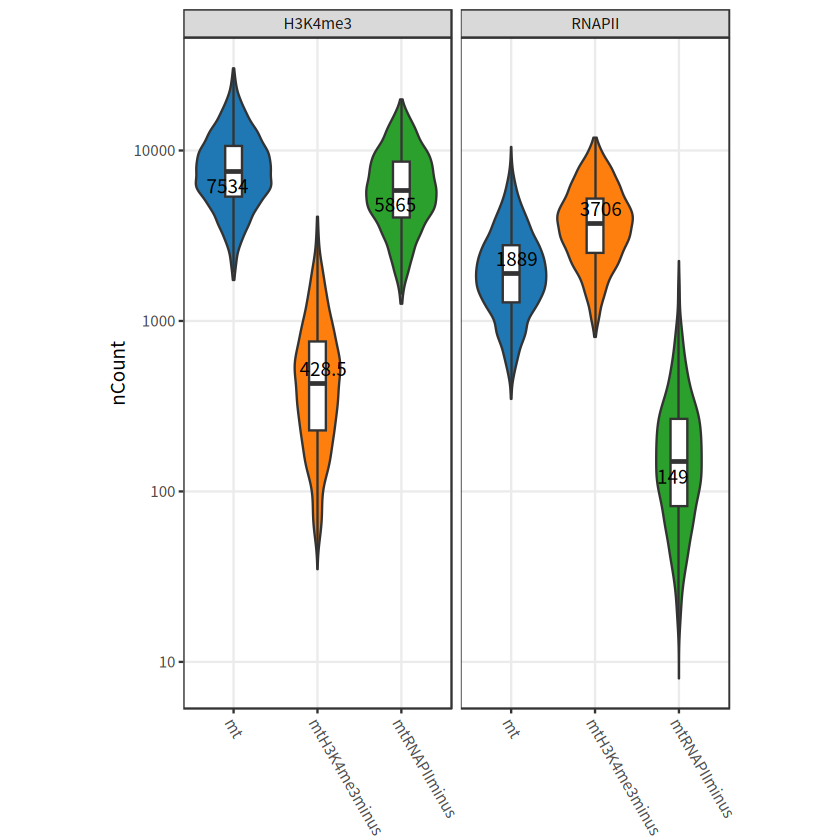

In [17]:
ncs_med <- metam %>%
  reframe(nCount = median(nCount),.by = c(target,con))
metam %>%
  ggplot(aes(con,nCount,fill = con)) + 
    geom_violin() + 
    geom_boxplot(width = .2,fill = 'white',
                 outlier.color = NA) +
    ggrepel::geom_text_repel(aes(label = nCount),data = ncs_med) + 
    theme_bw() +
    theme(legend.position = 'none',
          aspect.ratio = 2.5,panel.grid.minor = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(angle = -60,hjust = 0)) +
    scale_y_log10() + 
    facet_wrap(~target) +
    labs(y = 'nCount') + dfill

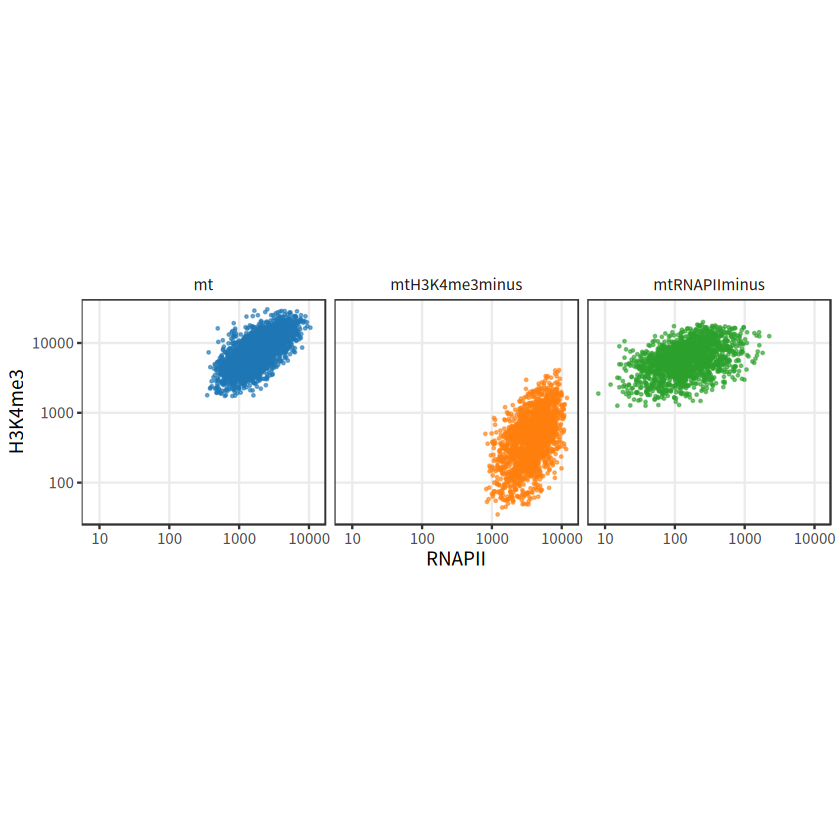

In [18]:
tmp <- metam %>%
  separate(cell,into = c("ab","cell"),sep = "_mt") %>%
  mutate(cell = paste0('mt',cell)) %>%
  dplyr::select(-data,-target) %>%
  spread(ab,nCount)
tmp_ <- tmp %>%
  reframe(RNAPII = median(RNAPII),
          H3K4me3 = median(H3K4me3),
          .by = c(con))
ggplot() + 
  theme_bw() +
  geom_point(aes(RNAPII,H3K4me3,color = con),tmp,size = .3,alpha = .6) +
  facet_wrap(~con) + 
  coord_fixed() + 
  scale_x_log10() + scale_y_log10() +
  theme(panel.grid.minor = element_blank(),
        legend.position = 'none',
        strip.background = element_blank()) +
  dcolor

In [19]:
metam2 <- metam %>%
  unite(lab1,target,lab,remove = F) %>%
  dplyr::select(cell,target,con,rep,lab1,lab,nCount) %>%
  mutate(
    target = ifelse(
      target == 'RNAPII',
      ifelse(con == 'mtRNAPIIminus','PrimaryMinus',target),
      ifelse(con == 'mtH3K4me3minus','PrimaryMinus',target)
      )
    ) %>%
  tib2df()
mtmi <- CreateChromatinAssay(
  counts = sm,
  min.cells = 10,max.cells = 500,
  min.features = 0,
  sep = c("_","_")
)
mtmi <- CreateSeuratObject(
  counts = mtmi,
  assay = "peaks",
  meta.data = metam2
)
use <- mgene_coding %>%
  GenomicRanges::reduce() %>%
  findOverlapPairs(reg2gr(rownames(mtmi))) %>%
  .@second %>% gr2reg() %>% unique()
mtmi <- RunTFIDF(mtmi)
mtmi <- FindTopFeatures(mtmi, min.cutoff = 'q0')
mtmi <- RunSVD(mtmi,features = use)
mtmi <- RunUMAP(mtmi,reduction = 'lsi',dims = 1:6)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

13:13:23 UMAP embedding parameters a = 0.9922 b = 1.112

13:13:23 Read 13386 rows and found 6 numeric columns

13:13:23 Using Annoy for neighbor search, n_neighbors = 30

13:13:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:13:25 Writing NN index file to temp file /tmp/RtmpEKvfTK/file9a2e3dae8daa

13:13:25 Searching Annoy index using 1 thread, search_k = 3000

13:13:31 Annoy recall = 100%

13:13:32 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:13:35 Initializing from normalized Laplacian + noise (using RSpectra)

13:13:35 Commencing optimization for 200 epochs, with 511978 positive edges

13:13:35 Using rng type: pcg

13:13:41 Optimization finishe

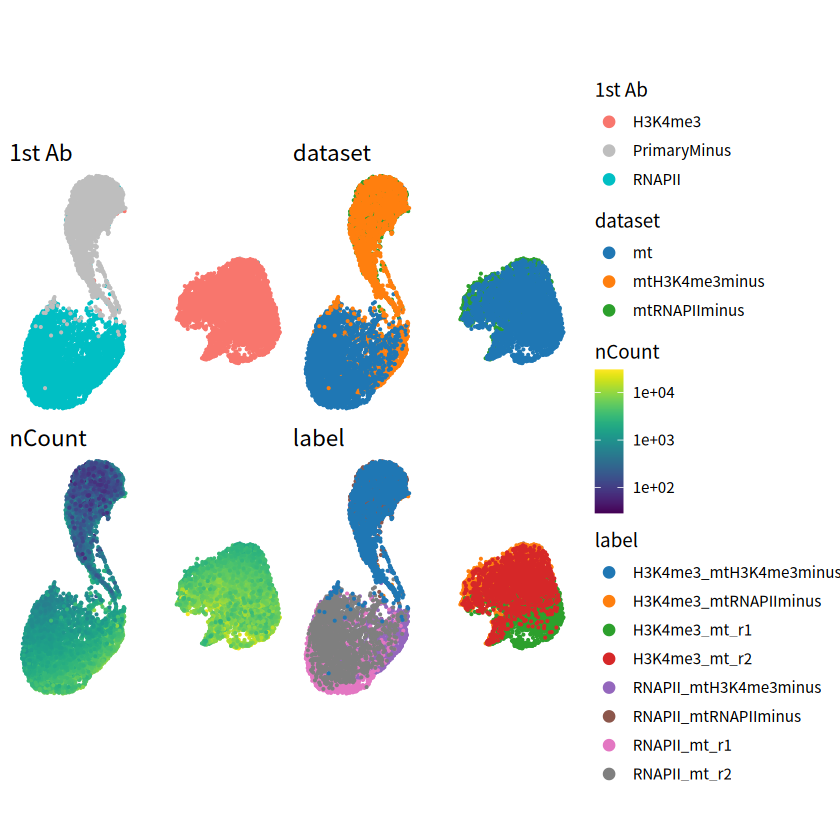

In [20]:
pal <- structure(c(ggColorHue(2),'gray'),names = c('H3K4me3','RNAPII','PrimaryMinus'))
g1 <- dimplot(mtmi,'target',palette = F) + theme_void() + scale_color_manual(values = pal) + ggtitle('1st Ab') + labs(color = '1st Ab')
g2 <- dimplot(mtmi,'con') + theme_void() + ggtitle('dataset') + labs(color = 'dataset')
g3 <- dimplot(mtmi,'nCount',scale_color_log10 = T) + theme_void() + labs(color = 'nCount')
g4 <- dimplot(mtmi,'lab1') + theme_void() + ggtitle('label') + labs(color = 'label')
patchwork::wrap_plots(list(g1,g2,g3,g4),guides = 'collect')

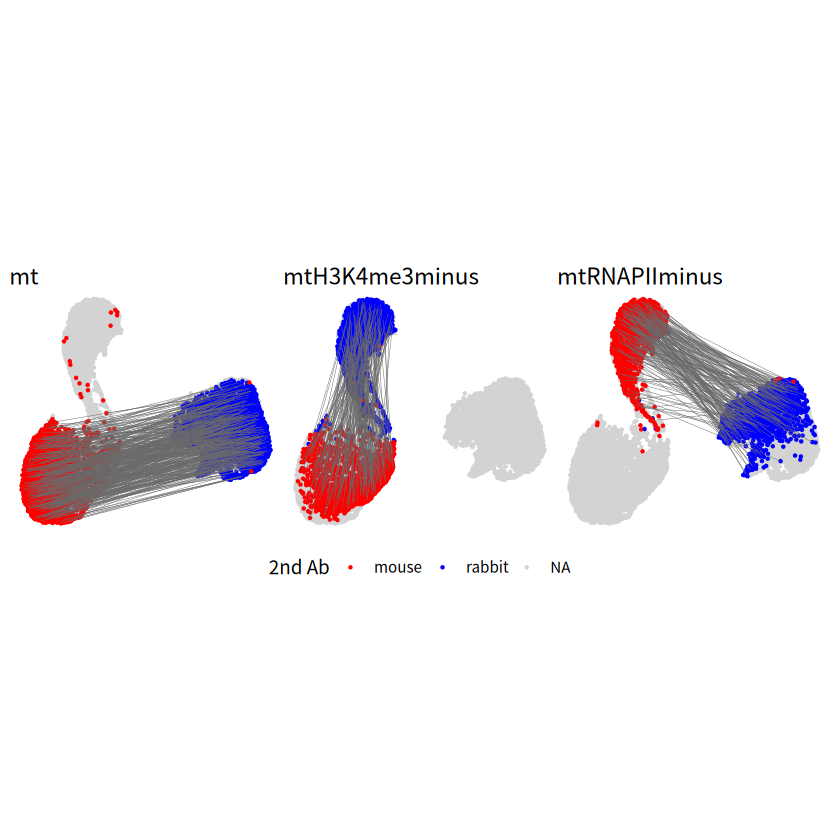

In [21]:
a1 <- seu2tab(mtmi) %>%
  mutate(
    type = orig.ident == 'RNAPII',
    cell = sub(".*:","",sub("_",":",sub("_","-",cell)))
    ) %>%
  unite(label,target,con,rep,remove = F)
a11 <- a1 %>% filter(type) %>%
  dplyr::select(cell,label,target,con,rep,UMAP1,UMAP2)
a12 <- a1 %>% filter(!type) %>%
  dplyr::select(cell,UMAP1,UMAP2) %>%
  rename(UMAP1_2 = UMAP1,UMAP2_2 = UMAP2)

labs <- c("mt","mtH3K4me3minus","mtRNAPIIminus")
set.seed(10)
a2 <- inner_join(a11,a12,by = 'cell') %>%
  nest(.by = label) %>%
  mutate(data = map(data,~{.x[sample(nrow(.x),200),]})) %>%
  unnest(data)
gs <- list()
for(i in labs){
  ii <- which(labs == i)
  a2_ <- a2 %>% filter(con == i)
  a1_ <- a1 %>% 
    mutate(ab = ifelse(type,'mouse','rabbit')) %>%
    mutate(ab = ifelse(con == i,ab,NA)) %>%
    arrange(ab)
  a1_ <- a1_[nrow(a1_):1,]
  gs[[i]] <- ggplot() +
    geom_point(aes(UMAP1,UMAP2,color = ab),a1_,size = .2) + 
    geom_segment(aes(UMAP1,UMAP2,xend = UMAP1_2,yend = UMAP2_2),a2_,size = .1,
                 color = 'dimgray',alpha = 1) +
    theme_void() +
    coord_fixed() + 
    scale_color_manual(values = c('red','blue'),
                       na.value = '#d3d3d3') +
    ggtitle(i) +
    labs(color = '2nd Ab')
}
gs %>% patchwork::wrap_plots(guides = 'collect') & theme(legend.position = 'bottom')

In [22]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3        forcats_1.0.0          stringr_1.5.1         
 [4] dplyr_1.1.4            purrr_1.0.4            readr_2.1.5           
 [7] tidyr_1.3.1            tibble_3.2.1           ggplot2_3.5.2         
[10] tidyver